In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 10 07:45:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0              26W /  70W |   4101MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
from torch.utils.data import TensorDataset

In [ ]:
def clean_text(text):
    if isinstance(text, (str, np.ndarray)): 
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        elif isinstance(text, np.ndarray):
            return np.array([clean_text(t) for t in text])
    elif pd.isnull(text): 
        return ""
    else:
        try:
            text = str(text)
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        except Exception as e:
            print(f"Error cleaning text: {e}, Text Type: {type(text)}, Text Value: {text}")
            return "" 

In [ ]:
labeled_data = pd.read_csv("/content/drive/MyDrive/WoS/data/WoSDataset_53949.csv")

for col in ['Keywords', 'Abstract']:
    labeled_data[col] = labeled_data[col].apply(clean_text)

labeled_data['combined_text'] = labeled_data['Keywords'] + " [SEP] " + labeled_data['Abstract']

In [ ]:
abstractslbl = labeled_data['Abstract']
keywordsslbl = labeled_data['Keywords']
domainlbl = labeled_data['Domain']
lbls = labeled_data['Label']

In [ ]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(53949, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [ ]:
labels = np.unique(domainlbl, return_counts=True)[0]
labelCounts=  np.unique(domainlbl, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 7773  5000  6303  4472 15641  8089  6671]


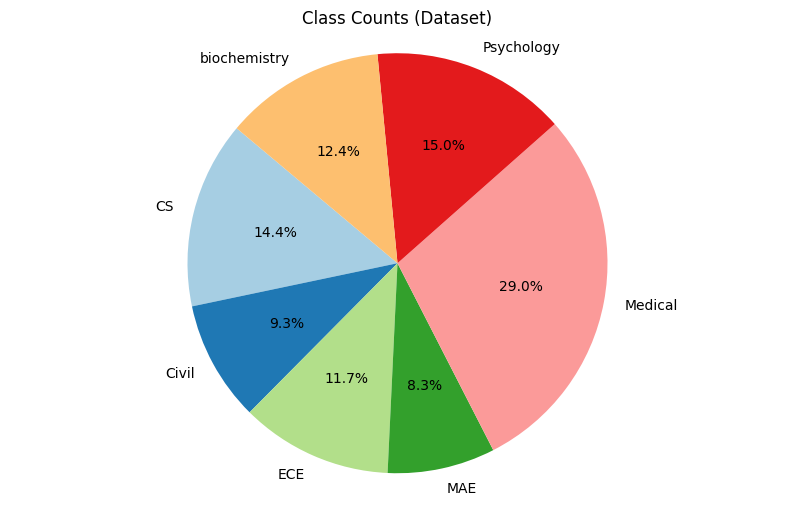

The label CS has 7773 records in the dataset.
The label Civil has 5000 records in the dataset.
The label ECE has 6303 records in the dataset.
The label MAE has 4472 records in the dataset.
The label Medical has 15641 records in the dataset.
The label Psychology has 8089 records in the dataset.
The label biochemistry has 6671 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
labeled_data_shuffled = sklearn.utils.shuffle(labeled_data)
abstracts_shuffled = labeled_data_shuffled['Abstract'].values
keywords_shuffled = labeled_data_shuffled['Keywords'].values
domains_shuffled = labeled_data_shuffled['Domain'].values
allLabels_shuffled = labeled_data_shuffled['Label'].values
allLabels_digit_shuffled = allLabels_shuffled.astype(int)

In [ ]:
print(np.shape(labeled_data_shuffled))
print(np.shape(abstracts_shuffled))
print(np.shape(keywords_shuffled))
print(np.shape(domains_shuffled))

print(labeled_data_shuffled['combined_text'][0])

(53949, 5)
(53949,)
(53949,)
(53949,)
 21dimensional nonlinear optical waves erbiumdoped optical fibre symbolic computation soliton solution soliton interaction         [SEP] 2  1dimensional nonlinear optical waves through the coherently excited resonant medium doped with the erbium atoms can be described by a 2  1dimensional nonlinear schrodinger equation coupled with the selfinduced transparency equations for such a system via the hirota method and symbolic computation linear forms one twoand nsoliton solutions are obtained asymptotic analysis is conducted and suggests that the interaction between the two solitons is elastic bright solitons are obtained for the fields e and p while the dark ones for the field n with e as the electric field p as the polarization in the resonant medium induced by the electric field and n as the population inversion profile of the dopant atoms headon interaction between the bidirectional two solitons and overtaking interaction between the unidirectional

In [ ]:
train_data, test_data = train_test_split(labeled_data_shuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

_, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))



(43159, 5)
(10790, 5)
(43159, 5)
(10790, 5)
(5395, 5)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
abstractslbltrain = train_data['Abstract']
keywordsslbltrain = train_data['Keywords']
domainlbltrain = train_data['Domain']
lblstrain = train_data['Label']

In [ ]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(53949, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [ ]:
labels = np.unique(domainlbltrain, return_counts=True)[0]
labelCounts=  np.unique(domainlbltrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 6202  3964  5011  3589 12566  6495  5332]


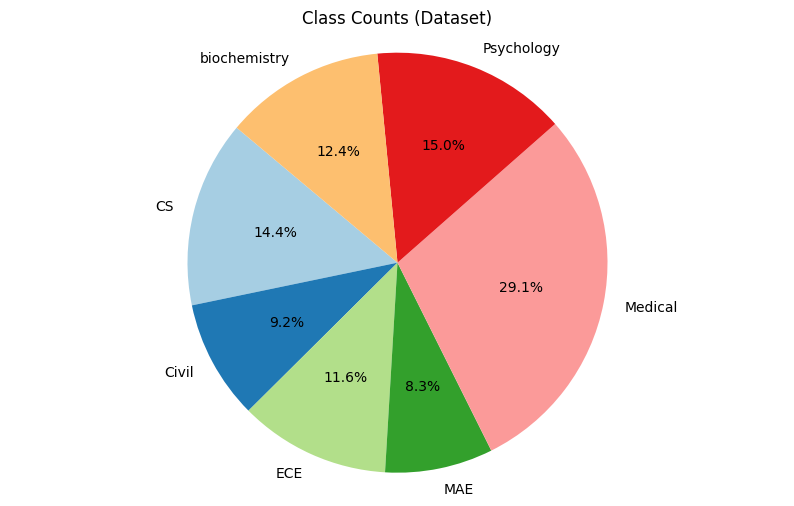

The label CS has 6202 records in the dataset.
The label Civil has 3964 records in the dataset.
The label ECE has 5011 records in the dataset.
The label MAE has 3589 records in the dataset.
The label Medical has 12566 records in the dataset.
The label Psychology has 6495 records in the dataset.
The label biochemistry has 5332 records in the dataset.


In [ ]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
abstractslbltest = test_data['Abstract']
keywordsslbltest = test_data['Keywords']
domainlbltest = test_data['Domain']
lblstest = test_data['Label']

In [ ]:
labels = np.unique(domainlbltest, return_counts=True)[0]
labelCounts=  np.unique(domainlbltest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1571 1036 1292  883 3075 1594 1339]


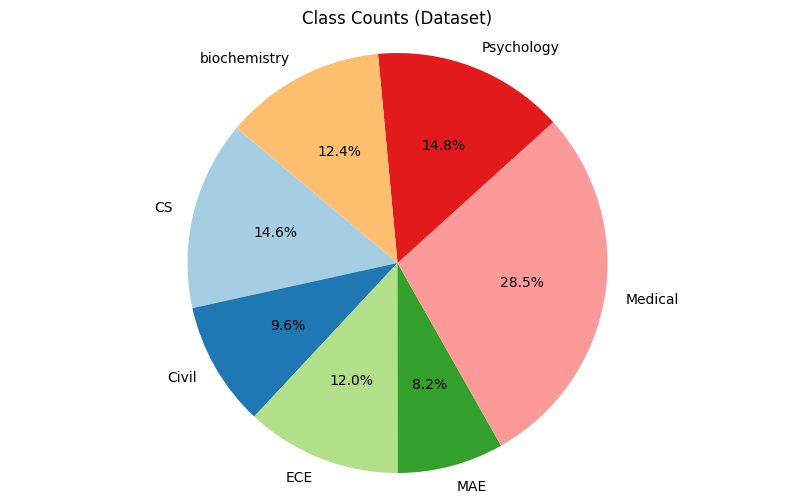

The label CS has 1571 records in the dataset.
The label Civil has 1036 records in the dataset.
The label ECE has 1292 records in the dataset.
The label MAE has 883 records in the dataset.
The label Medical has 3075 records in the dataset.
The label Psychology has 1594 records in the dataset.
The label biochemistry has 1339 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
abstractslblval = val_data['Abstract']
keywordsslblval = val_data['Keywords']
domainlblval = val_data['Domain']
lblsval = val_data['Label']

In [ ]:
labels = np.unique(domainlblval, return_counts=True)[0]
labelCounts=  np.unique(domainlblval, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 791  525  643  420 1593  771  652]


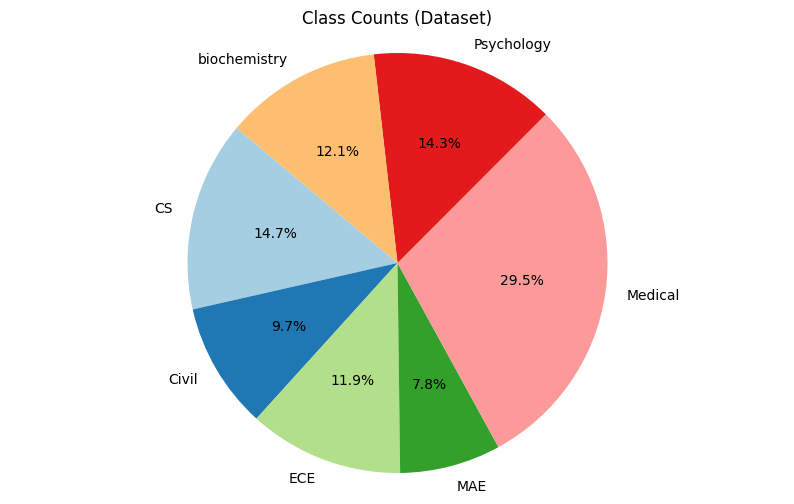

The label CS has 791 records in the dataset.
The label Civil has 525 records in the dataset.
The label ECE has 643 records in the dataset.
The label MAE has 420 records in the dataset.
The label Medical has 1593 records in the dataset.
The label Psychology has 771 records in the dataset.
The label biochemistry has 652 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
def encode_data(data, tokenizer, max_length=128, labeled=True):
    inputs = tokenizer(
        data['combined_text'].tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    if labeled and 'Label' in data.columns:
        labels = torch.tensor(data['Label'].values.astype(int))
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    else:
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'])


In [ ]:
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)

In [ ]:
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

In [ ]:
print(len(np.unique(train_data['Label'])))
model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=len(np.unique(train_data['Label'])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def calculate_metrics_f(valType, predictions, true_labels):
    if valType == 'test':
        cm = confusion_matrix(true_labels, predictions)
        report = classification_report(true_labels, predictions)
        f1_micro = f1_score(true_labels, predictions, average='micro')
        print("\nClassification Report:\n", report)
        return f1_micro
    elif valType == 'val':
        f1_micro = f1_score(true_labels, predictions, average='micro')
        return f1_micro

In [ ]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [ ]:

epochs = 20
learning_rates = [2e-5, 5e-6, 1e-6, 2e-6]
early_stopping_patience = 5
best_val_f1 = 0
early_stopping_counter = 0

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            model.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Train Loss: {avg_train_loss}")

        # Validation
        model.eval()
        predictions, true_labels = [], []
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits.detach().cpu().numpy()
            batch_predictions = np.argmax(logits, axis=1)
            predictions.extend(batch_predictions)
            true_labels.extend(labels.to('cpu').numpy())
        val_f1 = f1_score(true_labels, predictions, average='micro')
        print(f"Validation Micro F1: {val_f1}")
        val_micro_f1 = calculate_metrics_f('val', predictions, true_labels)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Val Micro F1: {val_micro_f1}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved.")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping applied.")
                break

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("Best model loaded.")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Training with learning rate: 2e-05


Epoch 1/20: 100%|██████████| 1349/1349 [14:07<00:00,  1.59batch/s]


Train Loss: 0.8861282625083043
Validation Micro F1: 0.8578313253012049
Epoch 1/20, Train Loss: 0.8861282625083043, Val Micro F1: 0.8578313253012049
Best model saved.


Epoch 2/20: 100%|██████████| 1349/1349 [14:15<00:00,  1.58batch/s]


Train Loss: 0.3541480417745126
Validation Micro F1: 0.8758109360518999
Epoch 2/20, Train Loss: 0.3541480417745126, Val Micro F1: 0.8758109360518999
Best model saved.


Epoch 3/20: 100%|██████████| 1349/1349 [14:15<00:00,  1.58batch/s]


Train Loss: 0.2628392354385711
Validation Micro F1: 0.8932344763670065
Epoch 3/20, Train Loss: 0.2628392354385711, Val Micro F1: 0.8932344763670065
Best model saved.


Epoch 4/20: 100%|██████████| 1349/1349 [14:14<00:00,  1.58batch/s]


Train Loss: 0.17259863223963376
Validation Micro F1: 0.8902687673772011
Epoch 4/20, Train Loss: 0.17259863223963376, Val Micro F1: 0.8902687673772011


Epoch 5/20: 100%|██████████| 1349/1349 [14:14<00:00,  1.58batch/s]


Train Loss: 0.10469486004568697
Validation Micro F1: 0.883595922150139
Epoch 5/20, Train Loss: 0.10469486004568697, Val Micro F1: 0.883595922150139


Epoch 6/20: 100%|██████████| 1349/1349 [14:15<00:00,  1.58batch/s]


Train Loss: 0.061579097040861244
Validation Micro F1: 0.8887859128822985
Epoch 6/20, Train Loss: 0.061579097040861244, Val Micro F1: 0.8887859128822985


Epoch 7/20: 100%|██████████| 1349/1349 [14:15<00:00,  1.58batch/s]


Train Loss: 0.03945270309803263
Validation Micro F1: 0.8878591288229842
Epoch 7/20, Train Loss: 0.03945270309803263, Val Micro F1: 0.8878591288229842


Epoch 8/20: 100%|██████████| 1349/1349 [14:15<00:00,  1.58batch/s]


Train Loss: 0.02837804710220482


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8911955514365153
Epoch 8/20, Train Loss: 0.02837804710220482, Val Micro F1: 0.8911955514365153
Early stopping applied.

Training with learning rate: 5e-06


Epoch 1/20: 100%|██████████| 1349/1349 [14:15<00:00,  1.58batch/s]


Train Loss: 0.012269796362872324
Validation Micro F1: 0.894902687673772
Epoch 1/20, Train Loss: 0.012269796362872324, Val Micro F1: 0.894902687673772
Best model saved.


Epoch 2/20: 100%|██████████| 1349/1349 [14:14<00:00,  1.58batch/s]


Train Loss: 0.007837061458683226
Validation Micro F1: 0.8943466172381835
Epoch 2/20, Train Loss: 0.007837061458683226, Val Micro F1: 0.8943466172381835


Epoch 3/20: 100%|██████████| 1349/1349 [14:20<00:00,  1.57batch/s]


Train Loss: 0.005519928092621453
Validation Micro F1: 0.8917516218721038
Epoch 3/20, Train Loss: 0.005519928092621453, Val Micro F1: 0.8917516218721038


Epoch 4/20: 100%|██████████| 1349/1349 [14:17<00:00,  1.57batch/s]


Train Loss: 0.004969210711595539
Validation Micro F1: 0.8936051899907321
Epoch 4/20, Train Loss: 0.004969210711595539, Val Micro F1: 0.8936051899907321


Epoch 5/20: 100%|██████████| 1349/1349 [14:17<00:00,  1.57batch/s]


Train Loss: 0.0032997052747034106
Validation Micro F1: 0.8934198331788693
Epoch 5/20, Train Loss: 0.0032997052747034106, Val Micro F1: 0.8934198331788693


Epoch 6/20: 100%|██████████| 1349/1349 [14:17<00:00,  1.57batch/s]


Train Loss: 0.0024494109428315554


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8945319740500464
Epoch 6/20, Train Loss: 0.0024494109428315554, Val Micro F1: 0.8945319740500464
Early stopping applied.

Training with learning rate: 1e-06


Epoch 1/20: 100%|██████████| 1349/1349 [14:17<00:00,  1.57batch/s]


Train Loss: 0.002179064246148611
Validation Micro F1: 0.8950880444856348
Epoch 1/20, Train Loss: 0.002179064246148611, Val Micro F1: 0.8950880444856348
Best model saved.


Epoch 2/20: 100%|██████████| 1349/1349 [14:16<00:00,  1.58batch/s]


Train Loss: 0.0015609833856779127
Validation Micro F1: 0.8947173308619092
Epoch 2/20, Train Loss: 0.0015609833856779127, Val Micro F1: 0.8947173308619092


Epoch 3/20: 100%|██████████| 1349/1349 [14:16<00:00,  1.57batch/s]


Train Loss: 0.0009570849083235945
Validation Micro F1: 0.8950880444856348
Epoch 3/20, Train Loss: 0.0009570849083235945, Val Micro F1: 0.8950880444856348


Epoch 4/20: 100%|██████████| 1349/1349 [14:17<00:00,  1.57batch/s]


Train Loss: 0.0008961446836823856
Validation Micro F1: 0.8950880444856348
Epoch 4/20, Train Loss: 0.0008961446836823856, Val Micro F1: 0.8950880444856348


Epoch 5/20: 100%|██████████| 1349/1349 [14:16<00:00,  1.57batch/s]


Train Loss: 0.0006474241641644106
Validation Micro F1: 0.8960148285449491
Epoch 5/20, Train Loss: 0.0006474241641644106, Val Micro F1: 0.8960148285449491
Best model saved.


Epoch 6/20: 100%|██████████| 1349/1349 [14:17<00:00,  1.57batch/s]


Train Loss: 0.001008487514749527
Validation Micro F1: 0.8954587581093605
Epoch 6/20, Train Loss: 0.001008487514749527, Val Micro F1: 0.8954587581093605


Epoch 7/20: 100%|██████████| 1349/1349 [14:16<00:00,  1.57batch/s]


Train Loss: 0.00068764387916175
Validation Micro F1: 0.897126969416126
Epoch 7/20, Train Loss: 0.00068764387916175, Val Micro F1: 0.897126969416126
Best model saved.


Epoch 8/20: 100%|██████████| 1349/1349 [14:15<00:00,  1.58batch/s]


Train Loss: 0.0009899836656456437
Validation Micro F1: 0.8952734012974977
Epoch 8/20, Train Loss: 0.0009899836656456437, Val Micro F1: 0.8952734012974977


Epoch 9/20: 100%|██████████| 1349/1349 [14:16<00:00,  1.57batch/s]


Train Loss: 0.0006879391939764765
Validation Micro F1: 0.8950880444856348
Epoch 9/20, Train Loss: 0.0006879391939764765, Val Micro F1: 0.8950880444856348


Epoch 10/20: 100%|██████████| 1349/1349 [14:15<00:00,  1.58batch/s]


Train Loss: 0.0006288608368254026
Validation Micro F1: 0.8941612604263207
Epoch 10/20, Train Loss: 0.0006288608368254026, Val Micro F1: 0.8941612604263207


Epoch 11/20: 100%|██████████| 1349/1349 [14:16<00:00,  1.57batch/s]


Train Loss: 0.0006400988949907204
Validation Micro F1: 0.8943466172381835
Epoch 11/20, Train Loss: 0.0006400988949907204, Val Micro F1: 0.8943466172381835


Epoch 12/20: 100%|██████████| 1349/1349 [14:16<00:00,  1.57batch/s]


Train Loss: 0.00041547991721832187


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8954587581093605
Epoch 12/20, Train Loss: 0.00041547991721832187, Val Micro F1: 0.8954587581093605
Early stopping applied.

Training with learning rate: 2e-06


Epoch 1/20: 100%|██████████| 1349/1349 [14:16<00:00,  1.57batch/s]


Train Loss: 0.0005547793661281322
Validation Micro F1: 0.8947173308619092
Epoch 1/20, Train Loss: 0.0005547793661281322, Val Micro F1: 0.8947173308619092
Early stopping applied.


<ipython-input-92-99034260d263>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Best model loaded.


In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[1445   37   12   13   14   20   30]
 [  24 1206    8   25   22    3    4]
 [   7    5 1363   12   13  175   19]
 [  21   30   12  780   24   10    6]
 [  18   21    8   23  958    3    5]
 [  22    3  171    8    8 2736  127]
 [  13    3   16    5    6  154 1142]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      1571
           1       0.92      0.93      0.93      1292
           2       0.86      0.86      0.86      1594
           3       0.90      0.88      0.89       883
           4       0.92      0.92      0.92      1036
           5       0.88      0.89      0.89      3075
           6       0.86      0.85      0.85      1339

    accuracy                           0.89     10790
   macro avg       0.90      0.89      0.89     10790
weighted avg       0.89      0.89      0.89     10790

Macro F1 Score: 0.8949078896095994
Micro F1 Score: 0.8924930491195552
Weighted F1 Score: 0.8

In [ ]:
# Calculate and display test metrics
print("\nTest Metrics:")
print("Confusion Matrix:\n", confusion_matrix(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))
print("Macro F1:", f1_score(true_labels, predictions, average='macro'))
print("Micro F1:", f1_score(true_labels, predictions, average='micro'))
print("Weighted F1:", f1_score(true_labels, predictions, average='weighted'))


Test Metrics:
Confusion Matrix:
 [[1445   37   12   13   14   20   30]
 [  24 1206    8   25   22    3    4]
 [   7    5 1363   12   13  175   19]
 [  21   30   12  780   24   10    6]
 [  18   21    8   23  958    3    5]
 [  22    3  171    8    8 2736  127]
 [  13    3   16    5    6  154 1142]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      1571
           1       0.92      0.93      0.93      1292
           2       0.86      0.86      0.86      1594
           3       0.90      0.88      0.89       883
           4       0.92      0.92      0.92      1036
           5       0.88      0.89      0.89      3075
           6       0.86      0.85      0.85      1339

    accuracy                           0.89     10790
   macro avg       0.90      0.89      0.89     10790
weighted avg       0.89      0.89      0.89     10790

Macro F1: 0.8949078896095994
Micro F1: 0.8924930491195552
Weighted F1: 0.89248

In [ ]:
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()
model.save_pretrained('/content/drive/MyDrive/WoS/SciBERT_WoS_53949_records')

NameError: name 'model' is not defined

In [ ]:
from google.colab import runtime
print('End of the runtime!')
runtime.unassign()

End of the runtime!
